# Análise de Questões
## I - Exposição do Problema

Este projeto iniciou-se a partir de um problema da startup em que faço parte. Um certo momento, levantou-se a necessidade de fornecer aos nossos usuários, questões de vestibulares para que eles possam estudar mais e ter mais conteúdos para se darem bem no vestibular.
Assim, criou-se um banco de dados com 120 mil questões
Porém, após validarmos os dados, identificou-se que nem todos as questões estavam classificadas de acordo com o assunto que elas pertenciam.
Assim, surgiu a ideia de implementar um modelo e treiná-lo, a fim de classificar cada questão de acordo com o assunto que essa questão pertence.

### Modelo
Para isso, foi necessário utilizar alguma técnica para a avaliação de textos.
Assim, idealizou-se usar o bag of words. Uma explicação simples é que o bag of words é uma lista que contem todas as palavras que estão nos textos de maneira não repetida.
Utilizamos ela para poder identificar as palavras mais recorrentes e entender se ela agregam na classificação das questões.



## II - Importação dos dados

Como os dados estavam no bando do Mongo. utilizei o framework do MongoDB para conectar e importar os dados para o Python

In [1]:
import numpy as np  

import bs4 as bs  
import urllib.request  
import re  
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('rslp')
from pymongo import MongoClient
import pandas as pd
from bson.regex import Regex

from dotenv import dotenv_values
config = dotenv_values(".env")


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mauri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mauri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\mauri\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


In [2]:
client = MongoClient(config["MONGO_CONNECTION_STRING"])
database = client["revisapp"]
collection = database["questions"]

In [3]:
query = {}

query["subjectName"] = u"matematica"
#query["testName"] = Regex(u"^.*ENEM.*$", "i")

projection = {}

projection["content"] = u"$content"
projection["subjectName"] = u"$subjectName"
projection["tags"] = u"$tags"
projection["_id"] = 0

sort = [(u"tags", -1)]

cursor = collection.find(query, projection=projection, sort=sort, limit=40000)
questoes = pd.array(list(cursor))


client.close()


In [4]:
#ajuste de colunas e dados
documents = pd.DataFrame(questoes)
# rename column
documents = documents.rename(columns = {"subjectName" : "level_1"})
# split tags
documents[['level_2','level_3']] = pd.DataFrame(documents.tags.tolist(), index=documents.index)
# drop tags column
documents = documents.drop("tags", axis="columns")
# drop those with "NaN or None"
documents = documents.dropna()

documents.shape


(16145, 4)

In [5]:
# coloca todas as sentenças em um array
corpus = []
for idx, document in documents.iterrows():
    corpus.append(document["content"])
#corpus

## III - Preparação dos dados
Para a aquisição das questões, foi feito uma ferramenta de webscrapping para captura das questões.
Assim, os dados são recebidos e inseridos no banco no formato HTML
Com isso, foi necessário convertê-los em texto utilizado a biblioteca BeautifulSoup.

In [6]:
# transforma tudo em lower case e remove os "desnecessário"
from bs4 import BeautifulSoup

for i in range(len(corpus )):
    corpus[i] = corpus[i].lower()
    corpus[i] = BeautifulSoup(corpus [i]).get_text() # transforma o HTML em texto
    corpus [i] = re.sub(r'\W',' ',corpus [i])  # remove os caracteres especiais
    corpus [i] = re.sub(r'\s+',' ',corpus [i]) # remove os caracteres especiais
    
#corpus

In [7]:
# validação das variáveis
print(len(corpus))
print(corpus[2])

16145
considerando se que as medidas em metros dos lados de um triângulo estão em progressão geométrica nessa ordem e são expressas por x 1 2x e x2 é correto afirmar que o perímetro desse triângulo mede


Como parte do processo de processamento de texto, é necessário verificar quais palavras são as mais frequentes, para que sejam usadas posteriormente.
Assim, foi utilizado a função "word_tokenize", que pega uma sentença e separa os dados em posições de uma lista.

In [21]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import RSLPStemmer
from unidecode import unidecode

stemmer = RSLPStemmer()


def stemSentence(sentence):
    token_words = word_tokenize(sentence)
    token_words
    stem_sentence = []
    for word in token_words:
        if word not in nltk.corpus.stopwords.words('portuguese'):
            word = stemmer.stem(word) # mantém apenas o radical da palavra
            word = unidecode(word) # remove acentos da palavra
            stem_sentence.append(word)  
            stem_sentence.append(" ")
    return "".join(stem_sentence)

In [30]:
stemmed_sentence = []
for sentence in corpus:
    stemmed_sentence.append(stemSentence(sentence))
stemmed_sentence

['med centimetr lad triangul express x 1 2x x2 5 progress aritme ness ord calcul perimetr triangul ',
 'sequ figur desenh malh quadricul indic tre prim etap form fract cad quadr dess malh are 1 cm2 ',
 'consider med metr lad triangul progress geometr ness ord express x 1 2x x2 corret afirm perimetr dess triangul med ',
 'sequ infinit triangul equilater pod ser constru inscrev triangul dentr outr part prim ',
 'consid triangul i ii iii caracter abaix atraves med lad triangul i 9 12 15 triangul ii 5 12 13 triangul iii 5 7 9 qual triangul retangul med lad progress aritme ',
 'sequ x 1 2x 1 5x 3 constitu progress aritme tre term cuj val represent med centimetr lad triangul dess mod corret afirm perimetr dess triangul centimetr igual ',
 'perimetr triangul retangul igual 6 0 m med lad progress aritme pa are dess triangul igual ',
 'triangul upe retangul med lad express centimetr numer natur form progress aritme ra 5 quant med are triangul upe ',
 'ness ord sequ 3 x y x y 8 respectiv term co

In [31]:
# cria um dicionário com as sentenças e a frequencia de cada um
wordfreq = {}
for sentence in stemmed_sentence:
    tokens = nltk.word_tokenize(sentence)
    for token in tokens:
        if token not in wordfreq.keys():
            wordfreq[token] = 1
        else:
            wordfreq[token] += 1

wordfreq


{'med': 3290,
 'centimetr': 296,
 'lad': 1530,
 'triangul': 1615,
 'express': 657,
 'x': 6346,
 '1': 5071,
 '2x': 416,
 'x2': 820,
 '5': 2308,
 'progress': 596,
 'aritme': 445,
 'ness': 1731,
 'ord': 504,
 'calcul': 640,
 'perimetr': 184,
 'sequ': 576,
 'figur': 3040,
 'desenh': 197,
 'malh': 64,
 'quadricul': 42,
 'indic': 948,
 'tre': 1544,
 'prim': 1657,
 'etap': 95,
 'form': 2605,
 'fract': 77,
 'cad': 3222,
 'quadr': 1782,
 'dess': 2805,
 'are': 1961,
 'cm2': 202,
 'consider': 1143,
 'metr': 1077,
 'geometr': 396,
 'corret': 1432,
 'afirm': 1974,
 'infinit': 138,
 'equilater': 237,
 'pod': 2779,
 'ser': 2373,
 'constru': 548,
 'inscrev': 33,
 'dentr': 328,
 'outr': 1133,
 'part': 1581,
 'consid': 1689,
 'i': 1112,
 'ii': 537,
 'iii': 401,
 'caracter': 19,
 'abaix': 1623,
 'atraves': 134,
 '9': 639,
 '12': 807,
 '15': 594,
 '13': 234,
 '7': 814,
 'qual': 436,
 'retangul': 1131,
 '5x': 86,
 '3': 3289,
 'constitu': 161,
 'term': 667,
 'cuj': 1191,
 'val': 3744,
 'represent': 2066,
 '

Após criar um array com a frequencia de cada palavra, é necessário eliminar as palavras "irrelevantes" para o nosso problema (stopwords), com o objetivo de reduzir o ruído dos dados analisados. Assim, se a palavra faz parte do conjunto de palavras do meu _stopwords_, altero a frequência da mesma para _zero_.

In [37]:
# remove a frequencia das palavras desnecessárias
for word in wordfreq:
    if (word.isnumeric()):  # removendo alguns "números" e variáveis (exemplo: x, y, etc..)
        wordfreq[word] = 0
#wordfreq


Agora, ordena-se essa lista considerando aqueles termos que aparecem com mais frequência. No nosso caso, selecionamos as 150 palavras mais frequêntes.

In [39]:
# pega os 40 mais frequente
import heapq

MOST_FREQUENT_NUMBER = 150  # 50~100 não muda mto

most_freq = heapq.nlargest(MOST_FREQUENT_NUMBER, wordfreq, key=wordfreq.get)
#most_freq


O ultimo passo é criar o saco de palavras transcrevendo cada documento para uma informação booleana dizendo se cada palavra do saco de palavras está presente ou não no documento. Se a palavra estiver na sentença, coloca 1, se não, 0.

In [40]:
sentence_vectors = []
for sentence in stemmed_sentence:
    sentence_tokens = nltk.word_tokenize(sentence)

    sent_vec = []
    for token in most_freq:
        if token in sentence_tokens:
            sent_vec.append(1)
        else:
            sent_vec.append(0)
    sentence_vectors.append(sent_vec)

sentence_vectors = np.array(sentence_vectors)
print(len(sentence_vectors))


16145


In [41]:
sentence_vectors

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [42]:
# imprimo os valores

dataset = pd.DataFrame(data=sentence_vectors, columns=most_freq)

dataset["classification"] = documents["level_2"]
# dataset = dataset.dropna() # remove NaN
sentence_vectors = np.array(dataset.drop("classification", 1))

np.unique(sentence_vectors)
print(len(dataset))
print(len(sentence_vectors))
print(dataset.head())


16145
16145
   x  numer  val  igual  r  pont  med  cad  b  figur  ...  vez  tip  defin  \
0  1      0    0      0  0     0    1    0  0      0  ...    0    0      0   
1  0      0    0      0  0     0    0    1  0      1  ...    0    0      0   
2  1      0    0      0  0     0    1    0  0      0  ...    0    0      0   
3  0      0    0      0  0     0    0    0  0      0  ...    0    0      0   
4  0      0    0      0  0     0    1    0  0      0  ...    0    0      0   

   altern  escolh  tabel  cond  cont  quatr     classification  
0       0       0      0     0     0      0                NaN  
1       0       0      0     0     0      0                NaN  
2       0       0      0     0     0      0  Álgebra Geometria  
3       0       0      0     0     0      0  Álgebra Geometria  
4       0       0      0     0     0      0  Álgebra Geometria  

[5 rows x 151 columns]


In [69]:
dataset.sample(5)

,x,numer,val,igual,r,pont,med,cad,b,figur,...,vez,tip,defin,altern,escolh,tabel,cond,cont,quatr,classification
9238,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Grandezas e medidas Razão e Proporção
3126,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Álgebra Matemática Financeira Números Probabil...
13655,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,Geometria
1223,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Álgebra
4930,1,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,Álgebra


## IV - Análise exploratória

## V - Modelagem

O modelo proposto foi desenhado de acordo com a classificação já existente no banco de dados. As classificações existentes consistiam na concatenação dos assuntos em que a questão estava envolvida.

Exemplos de classificação:
* Álgebra Matemática Financeira Números
* Noções de lógica Noções de Lógica Matemática
* Álgebra Grandezas e medidas Razão e Proporção

Pode-se observar que há diversos assuntos para uma questão única, o que nos mostra que esse é um problema com multiplas saídas/resultados.

In [44]:
#!pip install kneed
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split




import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, classification_report, confusion_matrix
from scikitplot.metrics import plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# import sklearn
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

Uma vez que o modelo foi desenhado para classificar os assuntos de matemática, foi necessário separar essa única classificação "conjuntas" em diversas classificações. Assim, levantou-se todas as possibilidades de assuntos existentes no banco de questões de matemática, criando assim um _array_ com 87 assuntos distintos.

In [45]:
# Array com os assuntos
subjects = ['Álgebra', 'Probabilidade e estatística', 'Números', 'Noções de lógica',
            'Noções de Lógica Matemática', 'Matemática Financeira', 'Grandezas e medidas', 'Razão e Proporção',
            'Geometria', 'Estatística', 'Determinantes', 'Álgebra linear', 'Análise Combinatória', 'Arcos na Circunferência',
            'Área e Perímetro das Figuras Planas', 'Aritmética', 'Arranjo', 'Cálculo diferencial integral', 'Cilindros', 'Circunferência',
            'Circunferência e Círculo', 'Combinação', 'Comprimento', 'Volume', 'Cones', 'Esfera', 'Congruência de Triângulos',
            'Cônicas', 'Conjuntos', 'Conjuntos Função', 'Decimal', 'Equação do Primeiro Grau', 'Equação do Segundo Grau',
            'Equações', 'Equações polinomiais', 'Equações polinomiais Exponenciais', 'Esfera', 'Expressões algébricas', 'Expressões algébricas',
            'Fatorial', 'Função', 'Função Exponencial', 'Função Logarítmica', 'Razões e proporções',
            'Função Quadrática', 'Função Trigonometria', 'Funções Definidas por Várias Sentenças', 'Funções Trigonométricas', 'Fundamentos',
            'Geometria analítica', 'Geometria espacial', 'Geometria plana', 'Gráficos', 'Inequação do Segundo Grau', 'Inequações', 'Inequações polinomiais',
            'Inequações polinomiais', 'Juros Compostos', 'Juros Simples', 'Lógica matemática', 'Prismas', 'Médias',
            'Ponderada', 'Porcentagem', 'Probabilidade', 'Múltiplos e Divisores', 'Notação científica',
            'Outros', 'Permutação', 'Pirâmides', 'Polígonos', 'Porcentagem', 'Princípio Fundamental da Contagem', 'Prismas', 
            'Problemas sobre as 4 operações', 'Razões Trigonométricas no Triângulo Retângulo', 'Relações Métricas do Triângulo Retângulo',
            'Relações Métricas em Triângulos Quaisquer', 'Reta', 'Retas e Planos', 'Sequências', 'Sistema de Numeração e Métrico', 'Superfície Poliédrica e Poliedros',
            'Tempo', 'Trigonometria', 'Troncos', 'Volume']

len(subjects)

87

Como feito nas questões, o _output_ foi dividido igual o bag of words implementado no enunciado das questões. Para o treinamento do modelo, foi colocado 1 ou 0 se o assunto pertencia àquela questão ou não.

In [46]:
# Separa em tags criando colunas novas de acordo com qual Subject
##  ESTÁ DEMORANDO DEMAIS. TENTAR ENCONTRAR OUTRO JEITO
df = documents
for index, document in df.iterrows():
    i = 0
    for subject in subjects:
        i += 1
        column_name = "tag_"+str(i)
        if (subject in document["level_2"]) or (subject in document["level_3"]):
            df.loc[index, subject] = 1
        else:
            df.loc[index, subject] = 0

#df

In [47]:
#imprime um sample
df.sample(3)


,content,level_1,level_2,level_3,Álgebra,Probabilidade e estatística,Números,Noções de lógica,Noções de Lógica Matemática,Matemática Financeira,...,Relações Métricas do Triângulo Retângulo,Relações Métricas em Triângulos Quaisquer,Reta,Retas e Planos,Sequências,Sistema de Numeração e Métrico,Superfície Poliédrica e Poliedros,Tempo,Trigonometria,Troncos
963,"<p>Considere o sistema abaixo</p> <p style=""te...",matematica,Álgebra,Álgebra linear,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15230,<p>A figura representa um bolo de três andares...,matematica,Geometria,Cilindros Geometria espacial Geometria plana,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4027,<p>Um dos últimos relatórios da ONU afirmava q...,matematica,Álgebra Geral Números,Aritmética População - Geral População e socie...,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
# faz o drop das colunas "desnecessárias" para o treinamento
columns_to_drop = ["content", "level_1", "level_2", "level_3"]
df = df.drop(columns=columns_to_drop)

# #df = df.dropna()
df


,Álgebra,Probabilidade e estatística,Números,Noções de lógica,Noções de Lógica Matemática,Matemática Financeira,Grandezas e medidas,Razão e Proporção,Geometria,Estatística,...,Relações Métricas do Triângulo Retângulo,Relações Métricas em Triângulos Quaisquer,Reta,Retas e Planos,Sequências,Sistema de Numeração e Métrico,Superfície Poliédrica e Poliedros,Tempo,Trigonometria,Troncos
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16615,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16618,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Divisão dos dados em dados de treino e teste


In [58]:
# Separa entre X(dados de entrada) e y(saídas dos dados de entrada)
X = sentence_vectors
y = df

# pca = PCA(n_components=40)
# pca.fit(X)
# X = pca.transform(X)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)


In [59]:
print(X_train)
#print(X_test)
#print(y_train)
#print(y_test)

[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 1 0]
 [1 1 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]]


### testes de classificadores

Como o problema consiste em uma classificação de multiplas saídas, foi utilizado a classe _MultiOutputClassifier_ da biblioteca _sklearn_.
Para que essa classe funcione corretamente, é necessário escolher um _estimator_, que, nesse caso, utilizamos o _RandomForestClassifier_.

O nome (Classificador Floresta Aleatória) explica muito bem o funcionamento do algoritmo, que irá criar muitas árvores de decisão, de maneira aleatória, formando o que podemos enxergar como uma floresta, onde cada árvore será utilizada na escolha do resultado final.

Durante o processo de contrução do modelo, tambpem foi testado o _KNeighborsClassifier_ e o _MLPClassifier_, porém com resultados inferiores ao _RandomForestClassifier_.

In [60]:
# Setup do classificador e treinamento
#clf = MultiOutputClassifier(MLPClassifier(hidden_layer_sizes=(32, 16))) #30% com (32,16)
# clf = MultiOutputClassifier(KNeighborsClassifier()) # 35%
clf = MultiOutputClassifier(RandomForestClassifier(max_depth=24, min_samples_leaf=6)) # 40.9% com 100 e 3k questões sem pca
# treina
clf.fit(X_train, y_train)


MultiOutputClassifier(estimator=RandomForestClassifier(max_depth=24,
                                                       min_samples_leaf=6))

In [61]:
# aplica
y_pred = clf.predict(X_test)
y_pred.shape


(3229, 81)

In [62]:
y_pred.shape

(3229, 81)

Agora, é feito o teste para avaliar se o treinamento deu certo.
Crio-se um vetor (hits) que me mostra quais predições foram corretas. Como se trata de um problema de multiplas saídas, foi avaliado se pelo menos 1 assunto foi predito corretamente.
No início, foi testado apenas as classificações que bateram 100% com as classificações de teste, porém, os valores eram muito baixos e não fez sentido ao problema que tínhamos.
Nesse caso e aplicado ao problema que tínhamos, tendo apenas uma ou mais classificações corretas, ja nos atendia e resolvia o problema.

In [63]:
# testa se o treinamento deu certo.
# crio um vetor (hits) que me mostra quais predições foram corretas.
# imprimo a taxa de acerto
# hits = np.alltrue((y_pred == y_test).values, axis=1) # todas os assuntos tem que ser iguais por questão
hits = np.any((y_pred + y_test) > 1, axis=1) # pelo menos 1 assunto tem que ser igual
rates = np.sum((y_pred + y_test) > 1, axis=1)/np.sum((y_pred + y_test) > 0, axis=1) # pegar a taxa de acerto dos assuntos por questão - só pega o que foi predito
print("taxa de acerto: ", round(hits.sum()/len(hits)*100,2), "%")
rates.shape
#hits
#rates

taxa de acerto:  74.11 %


(3229,)

Assim, após inúmeros treinos e respostas do modelo, observou-se que temos uma taxa de acerto média de 65%.

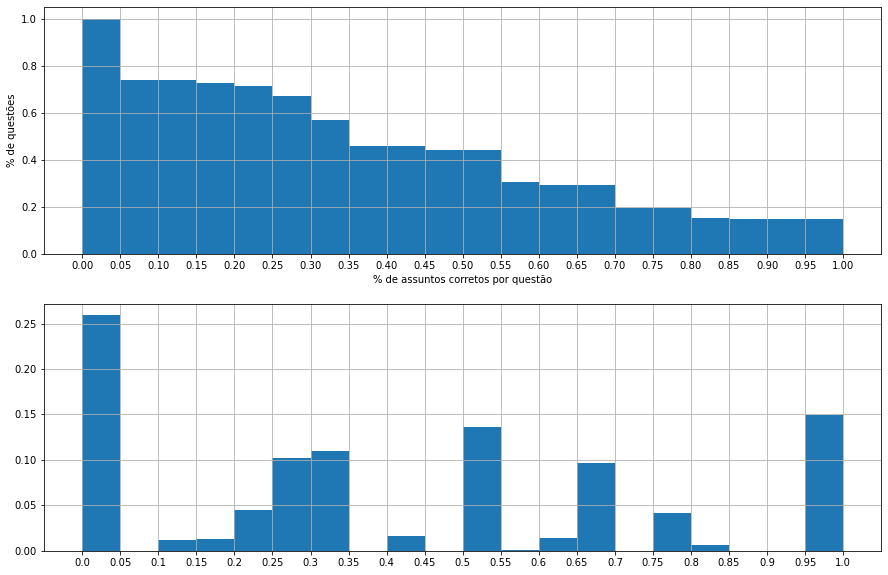

In [64]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
plt.grid()
plt.xlabel("% de assuntos corretos por questão")
plt.ylabel("% de questões")
plt.hist(rates, bins=20, cumulative=-1, density=True); 
plt.xticks(np.linspace(0,1,21))
plt.subplot(2,1,2)
plt.grid()
plt.hist(rates*20, bins=20, cumulative=0, density=True, stacked=True);
plt.xticks(np.linspace(0,20,21),np.around(np.linspace(0,1,21),2)) # ajuste do eixo X - de 0 até 1
plt.savefig('model_output.png')

In [65]:
rates


14216    0.750000
13205    0.333333
16244    0.000000
13958    0.666667
8664     0.333333
           ...   
4277     0.111111
5146     0.333333
3249     0.250000
1659     0.600000
7372     0.500000
Length: 3229, dtype: float64

1 - Como explicar melhor os gráficos
    - os graficos são complementares
2 - Análise Exploratória
    - Histograma mostrando a distribuição, as classificações
    - numero de assuntos por questão
    - termos mais recorrentes
    - wordcloud
    - respostas para perguntas
    - quantas questões eu tenho por assunto?
    - qual a variação - desvio padrão, variancia
3 - Modelo - como explicar melhor
    - referencia - URL do sklearn
    - https://link.springer.com/content/pdf/10.1023/A:1010933404324.pdf

--------
remover acentos 
manter os radicais apenas
--------
tempo - frequencia - sazonalidade
scipy - biblioteca com transformada de fourier - "irmã" no numpy
https://pt.wikipedia.org/wiki/Transformada_de_Fourier
